# Word2Vec (Skipgram )

In [2]:

import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

In [3]:
np.__version__, torch.__version__

('1.21.5', '1.12.1')

In [4]:
import matplotlib
matplotlib.__version__

'3.6.2'

## 1. Load data

In [5]:

#corpus is defined as a set of documents
corpus = ["apple banana fruit", "banana apple fruit", "banana fruit apple", 
          "dog cat animal", "cat dog animal", "cat animal dog"]

In [6]:
#1. tokenize
corpus_tokenized = [sent.split(" ") for sent in corpus]
corpus_tokenized  #we called each of this as "tokens", NOT words

[['apple', 'banana', 'fruit'],
 ['banana', 'apple', 'fruit'],
 ['banana', 'fruit', 'apple'],
 ['dog', 'cat', 'animal'],
 ['cat', 'dog', 'animal'],
 ['cat', 'animal', 'dog']]

In [7]:
#2. numericalize

flatten = lambda l: [item for sublist in l for item in sublist]
vocabs  = list(set(flatten(corpus_tokenized)))  #vocabs is a term defining all unique words your system know

In [8]:
#2.2 assign id to all these vocabs
word2index = {v: idx for idx, v in enumerate(vocabs)}

In [9]:
word2index['dog']

1

In [13]:
vocabs.append('<UNK>') 

In [14]:
word2index['<UNK>'] = 6  

In [15]:
#create index2word dictionary
index2word = {v:k for k, v in word2index.items()}
index2word

{0: 'animal',
 1: 'dog',
 2: 'banana',
 3: 'cat',
 4: 'apple',
 5: 'fruit',
 6: '<UNK>'}

In [16]:
vocabs

['animal', 'dog', 'banana', 'cat', 'apple', 'fruit', '<UNK>', '<UNK>']

## 2. Prepare train data

In [18]:
skipgrams = []

for sent in corpus_tokenized:
    #for each sent ["apple", "banana", "fruit"]
    for i in range(1, len(sent) - 1): #start from 1 to second last
        center_word = sent[i]
        outside_words = [sent[i-1], sent[i+1]]  #window_size = 1
        for o in outside_words:
            skipgrams.append([center_word, o])

skipgrams
        

[['banana', 'apple'],
 ['banana', 'fruit'],
 ['apple', 'banana'],
 ['apple', 'fruit'],
 ['fruit', 'banana'],
 ['fruit', 'apple'],
 ['cat', 'dog'],
 ['cat', 'animal'],
 ['dog', 'cat'],
 ['dog', 'animal'],
 ['animal', 'cat'],
 ['animal', 'dog']]

In [19]:
def random_batch(batch_size, corpus):
    
    skipgrams = []

    #for each corpus
    for sent in corpus_tokenized:
        #for each sent ["apple", "banana", "fruit"]
        for i in range(1, len(sent) - 1): #start from 1 to second last
            center_word = word2index[sent[i]]
            outside_words = [word2index[sent[i-1]], word2index[sent[i+1]]]  #window_size = 1
            for o in outside_words:
                skipgrams.append([center_word, o])
                
    #only get a batch, not the entire list
    random_index = np.random.choice(range(len(skipgrams)), batch_size, replace=False)
             
    #appending some list of inputs and labels
    random_inputs, random_labels = [], []   
    for index in random_index:
        random_inputs.append([skipgrams[index][0]])  #center words, this will be a shape of (1, ) --> (1, 1) for modeling
        random_labels.append([skipgrams[index][1]])
        
    return np.array(random_inputs), np.array(random_labels)
    

In [20]:
input, label = random_batch(10, corpus_tokenized)

print(f"{input.shape}")
print(f"{label=}")

(10, 1)
label=array([[0],
       [3],
       [1],
       [0],
       [4],
       [2],
       [5],
       [5],
       [2],
       [1]])


## 3. Model

In [21]:
voc_size = len(vocabs)
voc_size

8

In [22]:
vocabs

['animal', 'dog', 'banana', 'cat', 'apple', 'fruit', '<UNK>', '<UNK>']

In [24]:
class Skipgram(nn.Module):
    
    def __init__(self, voc_size, emb_size):
        super(Skipgram, self).__init__()
        self.embedding_center_word  = nn.Embedding(voc_size, emb_size)  
        self.embedding_outside_word = nn.Embedding(voc_size, emb_size)
    
    def forward(self, center_word, outside_word, all_vocabs):
        
        #convert them into embedding
        center_word_embed  = self.embedding_center_word(center_word)     #(batch_size, 1, emb_size)
        outside_word_embed = self.embedding_outside_word(outside_word)   #(batch_size, 1, emb_size)
        all_vocabs_embed   = self.embedding_outside_word(all_vocabs)     #(batch_size, voc_size, emb_size)
        
        #bmm is basically @ or .dot , but across batches (i.e., ignore the batch dimension)
        top_term = outside_word_embed.bmm(center_word_embed.transpose(1, 2)).squeeze(2)
        #(batch_size, 1, emb_size) @ (batch_size, emb_size, 1) = (batch_size, 1, 1) ===> (batch_size, 1)
        
        top_term_exp = torch.exp(top_term) 
        
        lower_term = all_vocabs_embed.bmm(center_word_embed.transpose(1, 2)).squeeze(2)
         #(batch_size, voc_size, emb_size) @ (batch_size, emb_size, 1) = (batch_size, voc_size, 1) = (batch_size, voc_size)
         
        lower_term_sum = torch.sum(torch.exp(lower_term), 1) 
        
        loss_fn = -torch.mean(torch.log(top_term_exp / lower_term_sum))
        
        return loss_fn

In [25]:
#preparing all_vocabs

batch_size = 2

def prepare_sequence(seq, word2index):
    idxs = list(map(lambda w: word2index[w] if word2index.get(w) is not None else word2index["<UNK>"], seq))
    return torch.LongTensor(idxs)

all_vocabs = prepare_sequence(list(vocabs), word2index).expand(batch_size, voc_size)
all_vocabs.shape

torch.Size([2, 8])

In [26]:
voc_size

8

In [27]:
input, label = random_batch(batch_size, corpus_tokenized)
input 

array([[5],
       [0]])

In [28]:
label 

array([[2],
       [1]])

In [29]:
voc_size

8

In [30]:
emb_size = 2 
model = Skipgram(voc_size, emb_size)

In [31]:
input_tensor = torch.LongTensor(input)  
label_tensor = torch.LongTensor(label)  

In [32]:
torch.LongTensor(2)

tensor([0, 0])

In [33]:
torch.LongTensor([2])

tensor([2])

In [34]:
input_tensor.shape

torch.Size([2, 1])

In [35]:
label_tensor.shape

torch.Size([2, 1])

In [36]:
all_vocabs

tensor([[0, 1, 2, 3, 4, 5, 6, 6],
        [0, 1, 2, 3, 4, 5, 6, 6]])

In [37]:
loss = model(input_tensor, label_tensor, all_vocabs)

In [38]:
loss

tensor(2.0086, grad_fn=<NegBackward0>)

## 4. Training

In [39]:
batch_size = 2 
emb_size   = 2 
model      = Skipgram(voc_size, emb_size)

optimizer  = optim.Adam(model.parameters(), lr=0.001)

In [40]:
num_epochs = 5000
#for epoch
for epoch in range(num_epochs):

    #get random batch
    input_batch, label_batch = random_batch(batch_size, corpus)
    input_batch = torch.LongTensor(input_batch)
    label_batch = torch.LongTensor(label_batch)
    
    #loss = model
    loss = model(input_batch, label_batch, all_vocabs)
    
    #backpropagate
    loss.backward()
    
    #update alpha
    optimizer.step()
    
    #print epoch loss
    if (epoch + 1) % 1000 == 0:
        print(f"Epoch {epoch+1} | Loss: {loss:.6f} | Time: ??")

Epoch 1000 | Loss: 1.216724 | Time: ??
Epoch 2000 | Loss: 0.534701 | Time: ??
Epoch 3000 | Loss: 1.448289 | Time: ??
Epoch 4000 | Loss: 1.004397 | Time: ??
Epoch 5000 | Loss: 0.667942 | Time: ??


## 5. Plot the embeddings

In [41]:
vocabs

['animal', 'dog', 'banana', 'cat', 'apple', 'fruit', '<UNK>', '<UNK>']

In [42]:
banana = torch.LongTensor([word2index['banana']])
banana

tensor([2])

In [43]:
banana_center_embed = model.embedding_center_word(banana)
banana_outisde_embed = model.embedding_outside_word(banana)

banana_embed = (banana_center_embed + banana_outisde_embed) / 2
banana_embed

tensor([[ 4.2310, -0.1218]], grad_fn=<DivBackward0>)

In [44]:
def get_embed(word):
    try:
        index = word2index[word]
    except:
        index = word2index['<UNK>']
    
    word = torch.LongTensor([index])

    center_embed  = model.embedding_center_word(word)
    outside_embed = model.embedding_outside_word(word)
    
    embed = (center_embed + outside_embed) / 2
    
    return  embed[0][0].item(), embed[0][1].item()


In [45]:
#find embedding of fruit, cat
print(get_embed('fruit'))
print(get_embed('cat'))

print(get_embed('chaky'))

(5.397140979766846, 1.6728591918945312)
(-4.982204437255859, -2.778129816055298)
(-2.998368740081787, 4.093141555786133)


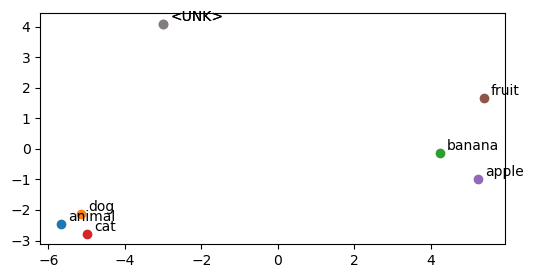

In [46]:
plt.figure(figsize=(6,3))
for i, word in enumerate(vocabs[:20]): #loop each unique vocab
    x, y = get_embed(word)
    plt.scatter(x, y)
    plt.annotate(word, xy=(x, y), xytext=(5, 2), textcoords='offset points')
plt.show()

## 6. Cosine similarity

In [48]:
vocabs

['animal', 'dog', 'banana', 'cat', 'apple', 'fruit', '<UNK>', '<UNK>']

In [49]:
cat          = get_embed('cat')
fruit        = get_embed('fruit')
animal       = get_embed('animal')

In [50]:
from numpy import dot
from numpy.linalg import norm

def cos_sim(a, b):
    cos_sim = dot(a, b)/(norm(a)*norm(b))
    return cos_sim
    
print(f"cat vs. fruit: ",        cos_sim(cat, fruit))
print(f"cat vs. animal: ",       cos_sim(cat, animal))
print(f"cat vs. cat: ",          cos_sim(cat, cat))

cat vs. fruit:  -0.9784242266496996
cat vs. animal:  0.995228795221219
cat vs. cat:  1.0


In [51]:
from scipy import spatial

def cos_sim(a, b):
    cos_sim = 1 - spatial.distance.cosine(a, b)  
    return cos_sim

print(f"cat vs. fruit: ",        cos_sim(cat, fruit))
print(f"cat vs. animal: ",       cos_sim(cat, animal))
print(f"cat vs. cat: ",          cos_sim(cat, cat))

cat vs. fruit:  -0.9784242266496996
cat vs. animal:  0.995228795221219
cat vs. cat:  1
